In [1]:
import sys
import re
from collections import defaultdict
from pprint import pprint
from joblib import Parallel, delayed
import time
import copy

WAV_FILE_PATH = 'data/input/waveforms.root'
DATASET_PATH = 'data/dataset/dataset.pkl'

import uproot
import pickle

import numpy as np
from matplotlib import pyplot as plt

from src.cfd import CFD

# Load file

In [2]:
N_JOBS = 8

In [3]:
SECTOR = 'sector 56'
STATION = 'station 220cyl'
RP = 'cyl_hr'

data_dir = f'wav/CTPPS/TimingDiamond/{SECTOR}/{STATION}/{RP}'

In [4]:
file_raw = uproot.open(WAV_FILE_PATH)

len(file_raw[data_dir].keys(recursive=False))

120017

In [5]:
sorted_events = sorted(file_raw[data_dir].keys(recursive=False), key=lambda x: int(x[6:-2]))
sorted_events[:20]

['event 3375;1',
 'event 6341;1',
 'event 7535;1',
 'event 8570;1',
 'event 9831;1',
 'event 9900;1',
 'event 10650;1',
 'event 11542;1',
 'event 13050;1',
 'event 14400;1',
 'event 15834;1',
 'event 15880;1',
 'event 17250;1',
 'event 17550;1',
 'event 18291;1',
 'event 19792;1',
 'event 20290;1',
 'event 22036;1',
 'event 23032;1',
 'event 24253;1']

# Produce the dataset

In [6]:
class WaveformData:
    def __init__(self, series, t0):
        self.series = series
        self.t0 = t0
        self.t_cfd = None
        
    @classmethod
    def from_channel_data(cls, channel_data):
        series = np.array(channel_data['wavCal'].values())
        series[1] = -series[1] + 1 # revert
        t0 = channel_data['t0'].members['fVal']
        return cls(series, t0)
    
    def get_metadata_str(self):
        return {
            't0': self.t0,
            't_cfd': self.t_cfd
        }.__str__()
    
class EventData:
    def __init__(self, planes):
        self.planes = planes
        self.t_cfd_average = None
        
    @classmethod
    def from_event_data(cls, event_data):
        planes = {}
        for plane_key, plane_data in event_data.items(recursive=False):
            plane_name = int(plane_key[6:-2])
            planes[plane_name] = {}
            for channel_key, channel_data in plane_data.items(recursive=False):
                channel_name = int(channel_key[8:-2])
                planes[plane_name][channel_name] = WaveformData.from_channel_data(channel_data)
        return cls(planes)
    
    def __str__(self):
        return {f'plane {plane_name}': {f'channel {channel_name}': f't0: {wav_data.t0}' for channel_name, wav_data in plane_data.items()} for plane_name, plane_data in self.planes.items()}.__str__()
    
    def get_metadata_dict(self):
        return {f'plane {plane_name}': {f'channel {channel_name}': wav_data.get_metadata_str() for channel_name, wav_data in plane_data.items()} for plane_name, plane_data in self.planes.items()}
    
    def get_plane_count(self):
        return len(self.planes)
    
    def get_hit_count(self):
        return sum(len(channels) for channels in self.planes.values())
    
    def get_all_waveforms(self):
        wavs = []
        for plane, channels in self.planes.items():
            for channel, wav_data in channels.items():
                wavs.append((plane, channel, wav_data))
                
        return wavs

In [7]:
# def find_slices(length, n):
#     interval = length // n
#     slices = [i * interval for i in range(n)] + [length]
#     return slices

# def transform_event_collection(file_raw, data_dir, events):
#     dataset = []
#     for event in events:
#         event_int = int(event[6:-2])
#         event_data = file_raw[data_dir][event]
#         dataset.append((event_int, EventData.from_event_data(event_data)))
#     return dataset

# start = time.time()
# slices = find_slices(len(sorted_events), N_JOBS)
# dataset = Parallel(n_jobs=N_JOBS)(delayed(transform_event_collection)(file_raw, data_dir, sorted_events[slices[i]:slices[i+1]]) for i in range(len(slices) - 1))
# dataset = dict(sum(dataset, []))
# end = time.time()
# print(f'Elapsed time: {end - start:0.2f} s')

# # store the dataset
# with open(DATASET_PATH, 'wb') as file:
#     pickle.dump(dataset, file)
    
# load the dataset
with open(DATASET_PATH, 'rb') as file:
    original_dataset = pickle.load(file)

In [8]:
print(original_dataset[3375])

{'plane 1': {'channel 11': 't0: -8.286604881286621'}, 'plane 2': {'channel 11': 't0: 0.12372398376464844'}, 'plane 3': {'channel 11': 't0: -5.702384948730469'}}


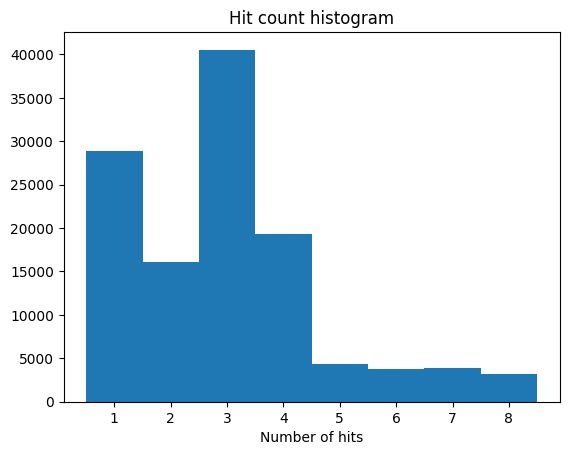

In [9]:
def plot_hit_count_histogram(dataset, title='Hit count histogram'):
    hit_count_histogram = [event_data.get_hit_count() for event_data in dataset.values()]

    plt.hist(hit_count_histogram, bins=range(1, 8 + 2), align='left')
    plt.title(title)
    plt.xlabel('Number of hits')
    
plot_hit_count_histogram(original_dataset)
plt.show()

In [10]:
file_raw.close()

# Remove saturated and noisy events

In [11]:
channel_vmax_thresholds = {
    (0, 2):  (0.45, 0.7), # everything seems to be noise?
    (0, 11): (0.4, 0.7),
    (1, 2):  (0.36, 0.72),
    (1, 11): (0.36, 0.72),
    (2, 2):  (0.38, 0.72),
    (2, 11): (0.34, 0.72),
    (3, 2):  (0.36, 0.72),
    (3, 11): (0.34, 0.72)
}

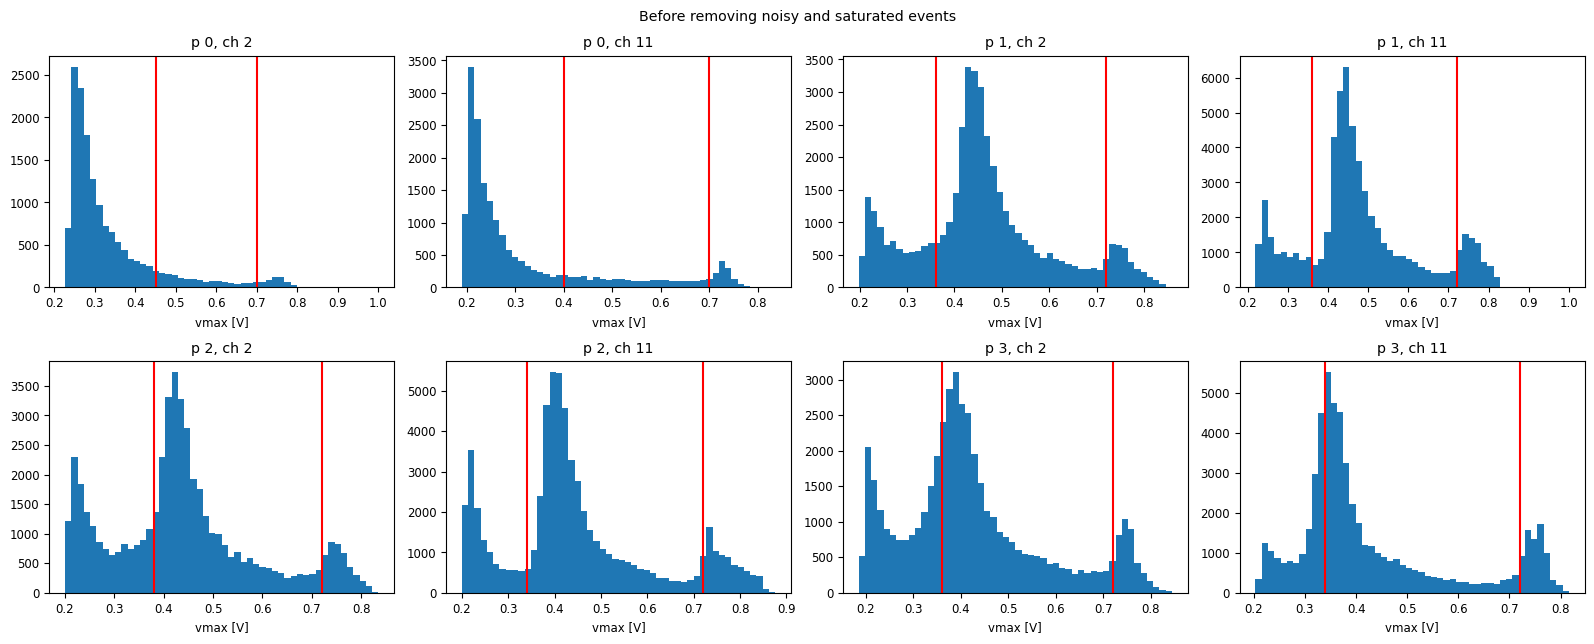

In [12]:
vmax_histograms = defaultdict(list)
for event, event_data in original_dataset.items():
    for plane, plane_data in event_data.planes.items():
        for channel, wav_data in plane_data.items():
            vmax_histograms[(plane, channel)].append(np.max(wav_data.series[1]))
            
plt.figure(figsize=(16, 6.5))
plt.rc('font', size=8.5)
for i, ((plane, channel), vmax_list) in enumerate(sorted(vmax_histograms.items())):
    thresholds = channel_vmax_thresholds[(plane, channel)]
    plt.subplot(2, 4, i + 1)
    plt.hist(vmax_list, bins=50)
    plt.axvline(thresholds[0], c='red')
    plt.axvline(thresholds[1], c='red')
    plt.title(f'p {plane}, ch {channel}')
    plt.xlabel('vmax [V]')
    
plt.suptitle('Before removing noisy and saturated events')
plt.tight_layout()
plt.show()

In [13]:
vmax_dataset = copy.deepcopy(original_dataset)

for event, event_data in vmax_dataset.items():
    for plane, plane_data in event_data.planes.items():
        for channel, wav_data in list(plane_data.items()):
            thresholds = channel_vmax_thresholds[(plane, channel)]
            if not thresholds[0] <= np.max(wav_data.series[1]) <= thresholds[1]:
                del plane_data[channel]

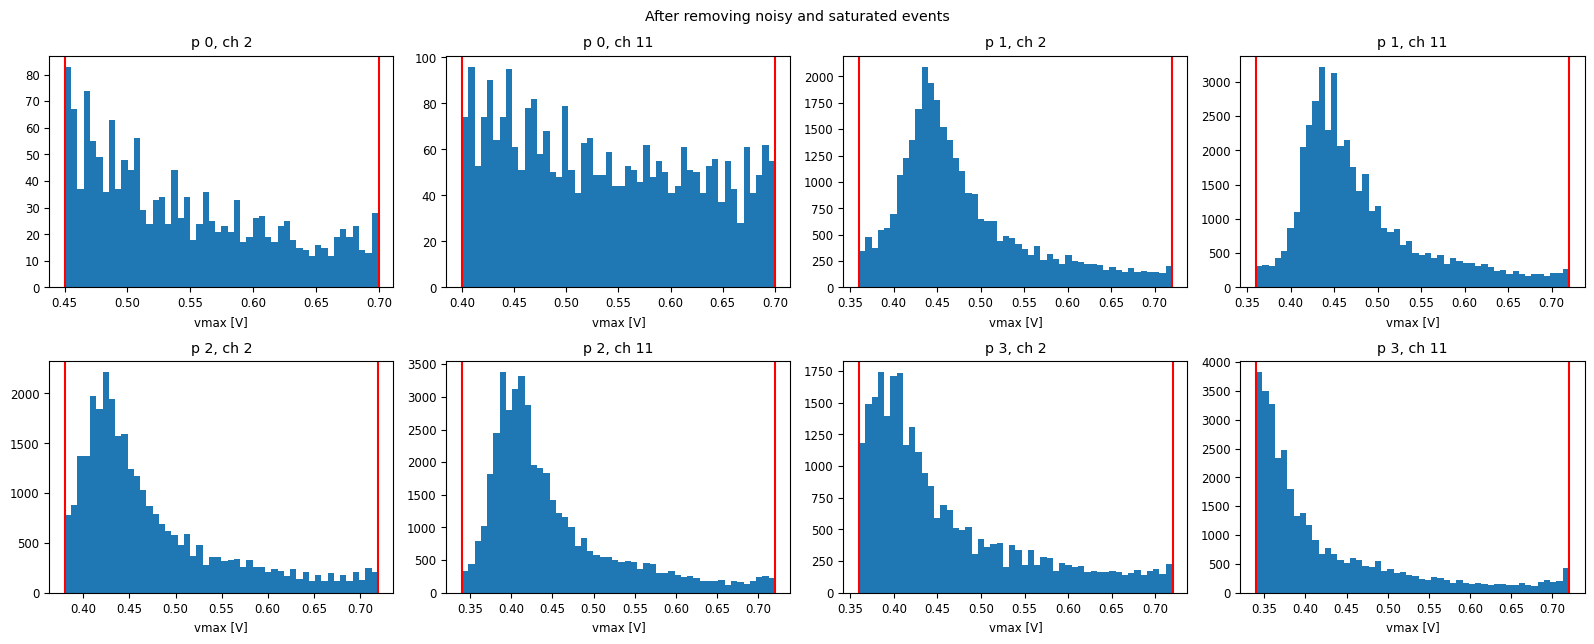

In [14]:
vmax_histograms = defaultdict(list)
for event, event_data in vmax_dataset.items():
    for plane, plane_data in event_data.planes.items():
        for channel, wav_data in plane_data.items():
            vmax_histograms[(plane, channel)].append(np.max(wav_data.series[1]))

plt.figure(figsize=(16, 6.5))
plt.rc('font', size=8.5)
for i, ((plane, channel), vmax_list) in enumerate(sorted(vmax_histograms.items())):
    thresholds = channel_vmax_thresholds[(plane, channel)]
    plt.subplot(2, 4, i + 1)
    plt.hist(vmax_list, bins=50)
    plt.axvline(thresholds[0], c='red')
    plt.axvline(thresholds[1], c='red')
    plt.title(f'p {plane}, ch {channel}')
    plt.xlabel('vmax [V]')
    
plt.suptitle('After removing noisy and saturated events')
plt.tight_layout()
plt.show()

# t0 histograms

In [15]:
# 8 1/3
channel_t0_thresholds = {
    (0, 2):  (-2, 1),
    (0, 11): (2, 5),
    (1, 2):  (-1.5, 1.5),
    (1, 11): (-2, 1),
    (2, 2):  (-1, 2),
    (2, 11): (-2, 1),
    (3, 2):  (-1.5, 1.5),
    (3, 11): (0, 3)
}

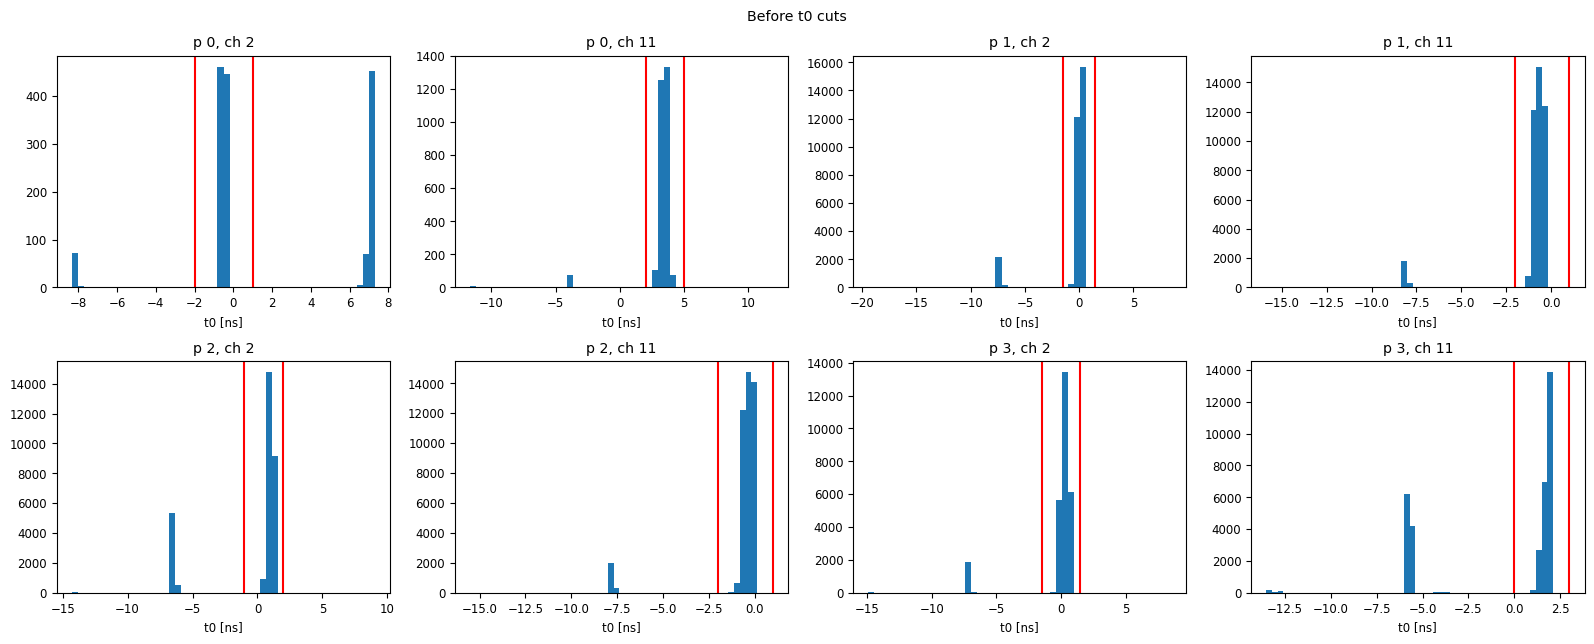

In [16]:
t0_dict = defaultdict(list)
for event_data in vmax_dataset.values():
    for plane, channel, wav_data in event_data.get_all_waveforms():
        t0_dict[(plane, channel)].append(wav_data.t0)
        
plt.figure(figsize=(16, 6.5))
plt.rc('font', size=8.5)

for i, (plane, channel) in enumerate(sorted(t0_dict.keys())):
    thresholds = channel_t0_thresholds[(plane, channel)]
    t0_arr = t0_dict[(plane, channel)]
    plt.subplot(2, 4, i + 1)
    plt.hist(t0_arr, bins=50)
    plt.axvline(thresholds[0], c='red')
    plt.axvline(thresholds[1], c='red')
    plt.title(f'p {plane}, ch {channel}')
    plt.xlabel('t0 [ns]')
    
plt.suptitle('Before t0 cuts')
plt.tight_layout()
plt.show()

In [17]:
t0_dataset = copy.deepcopy(vmax_dataset)

for event, event_data in t0_dataset.items():
    for plane, plane_data in event_data.planes.items():
        for channel, wav_data in list(plane_data.items()):
            thresholds = channel_t0_thresholds[(plane, channel)]
            if not thresholds[0] <= wav_data.t0 <= thresholds[1]:
                del plane_data[channel]

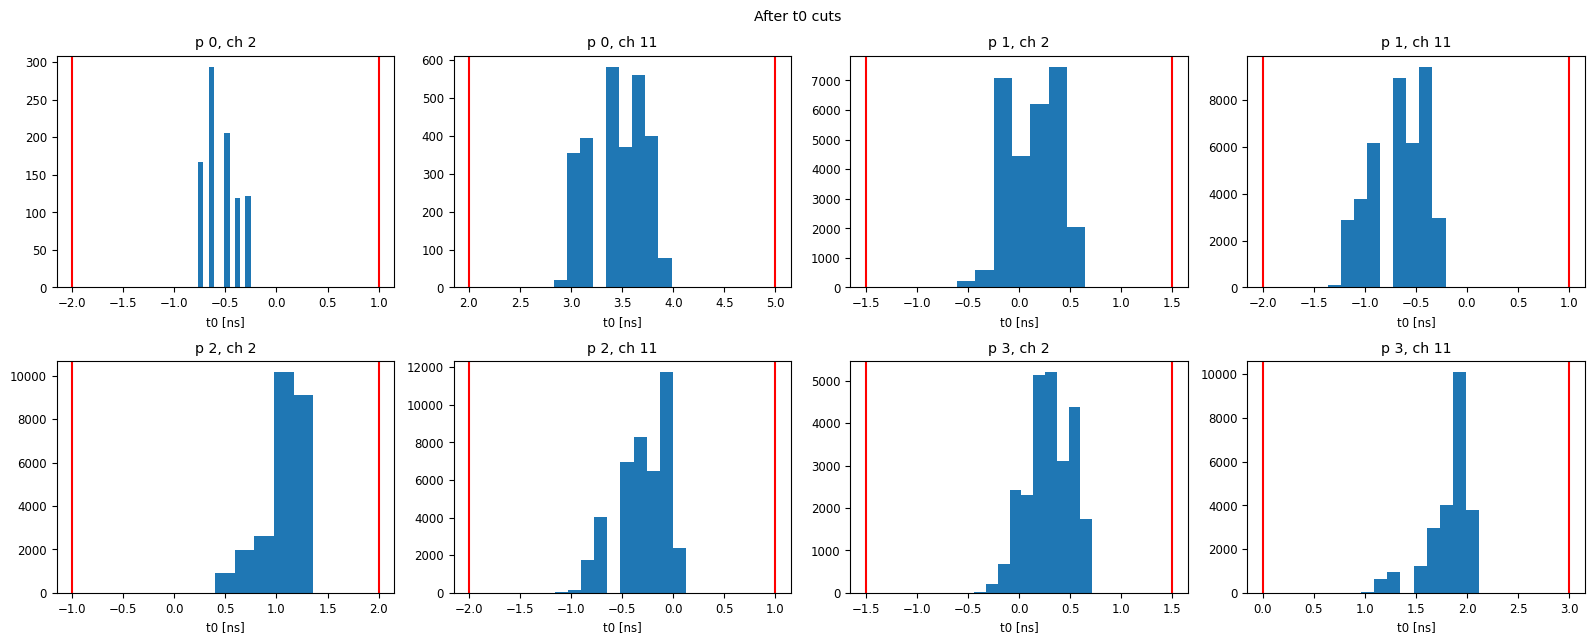

In [18]:
t0_dict = defaultdict(list)
for event_data in t0_dataset.values():
    for plane, channel, wav_data in event_data.get_all_waveforms():
        t0_dict[(plane, channel)].append(wav_data.t0)
        
plt.figure(figsize=(16, 6.5))
plt.rc('font', size=8.5)

for i, (plane, channel) in enumerate(sorted(t0_dict.keys())):
    thresholds = channel_t0_thresholds[(plane, channel)]
    t0_arr = t0_dict[(plane, channel)]
    plt.subplot(2, 4, i + 1)
    plt.hist(t0_arr, bins=10)
    plt.axvline(thresholds[0], c='red')
    plt.axvline(thresholds[1], c='red')
    plt.title(f'p {plane}, ch {channel}')
    plt.xlabel('t0 [ns]')
    
plt.suptitle('After t0 cuts')
plt.tight_layout()
plt.show()

# Calculate CFD timestamps and adjust t0

In [19]:
cfd_dataset = copy.deepcopy(t0_dataset)
cfd_avg_shift_applied = False

cfd = CFD(n_baseline=6)
for event, event_data in cfd_dataset.items():
    for plane, plane_data in event_data.planes.items():
        for channel, wav_data in list(plane_data.items()):
            t = cfd.predict(wav_data.series[0], wav_data.series[1])
            if t is None: # Remove the events where CFD cannot be calculated
                del plane_data[channel]
            else:
                wav_data.t_cfd = t

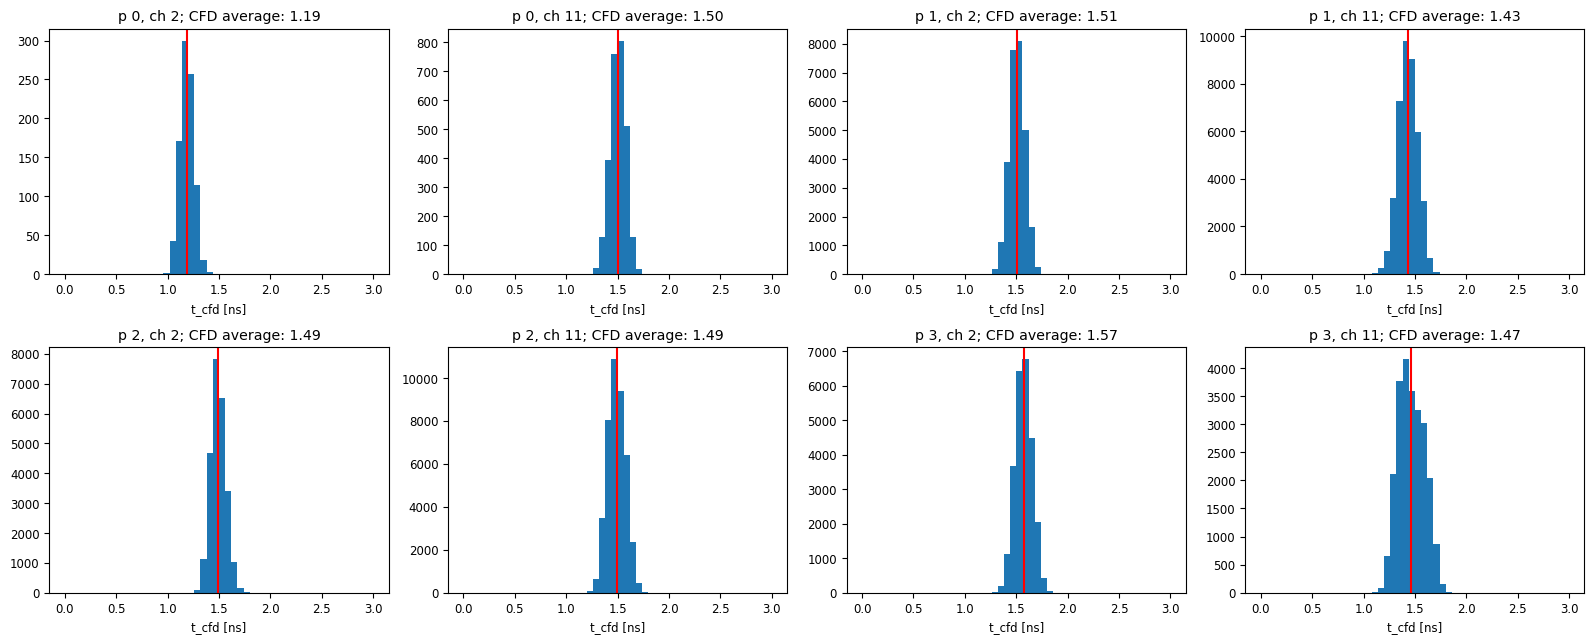

In [20]:
cfd_histograms = defaultdict(list)
for event, event_data in cfd_dataset.items():
    for plane, plane_data in event_data.planes.items():
        for channel, wav_data in plane_data.items():
            cfd_histograms[(plane, channel)].append(wav_data.t_cfd)
            
channel_cfd_averages = {}
for (plane, channel), cfds in sorted(cfd_histograms.items()):
    channel_cfd_averages[(plane, channel)] = np.average(cfds)

plt.figure(figsize=(16, 6.5))
plt.rc('font', size=8.5)
for i, ((plane, channel), cfds) in enumerate(sorted(cfd_histograms.items())):
    plt.subplot(2, 4, i + 1)
    plt.hist(cfds, bins=50, range=(0, 3))
    cfd_avg = channel_cfd_averages[(plane, channel)]
    plt.axvline(cfd_avg, c='red')
    plt.title(f'p {plane}, ch {channel}; CFD average: {cfd_avg:0.2f}')
    plt.xlabel('t_cfd [ns]')
    
plt.tight_layout()
plt.show()

In [21]:
if not cfd_avg_shift_applied:
    for event, event_data in cfd_dataset.items():
        for plane, plane_data in event_data.planes.items():
            for channel, wav_data in plane_data.items():
                # wav_data.t0 /= 7.8
                wav_data.t0 -= channel_cfd_averages[(plane, channel)]
                # pass

cfd_avg_shift_applied = True

# Calculate CFD event averages

In [22]:
for event, event_data in list(cfd_dataset.items()):
    cfds = [wav_data.t_cfd + wav_data.t0 for _, _, wav_data in event_data.get_all_waveforms()]
    if not cfds: # Remove event if empty after the selection
        del cfd_dataset[event]
    else:
        event_data.t_cfd_average = np.average(cfds)

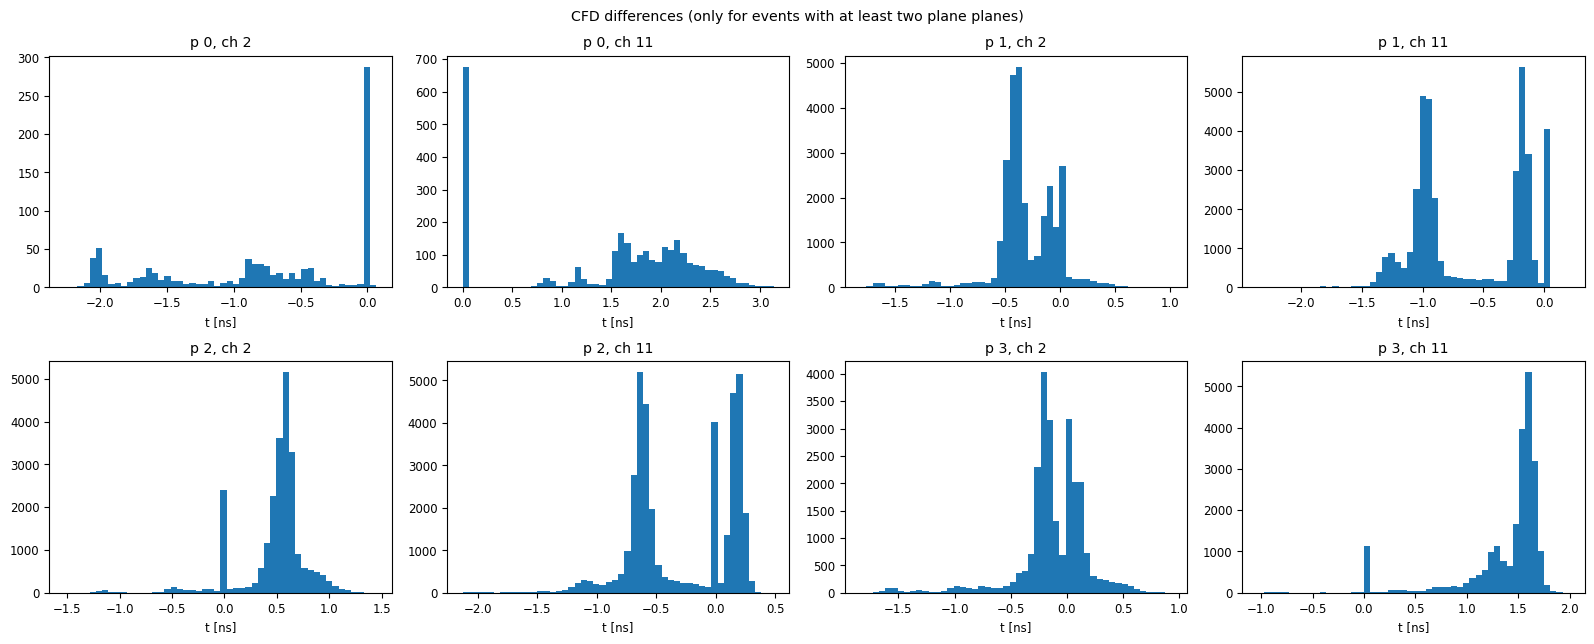

In [23]:
cfd_differences = defaultdict(list)
for event, event_data in cfd_dataset.items():
    if len(event_data.planes) > 1:
        for plane, plane_data in event_data.planes.items():
            for channel, wav_data in plane_data.items():
                cfd_differences[(plane, channel)].append(wav_data.t_cfd + wav_data.t0 - event_data.t_cfd_average)
            
plt.figure(figsize=(16, 6.5))
plt.rc('font', size=8.5)
for i, ((plane, channel), cfds) in enumerate(sorted(cfd_differences.items())):
    plt.subplot(2, 4, i + 1)
    plt.hist(cfds, bins=50)
    plt.title(f'p {plane}, ch {channel}')
    plt.xlabel('t [ns]')
    
plt.suptitle('CFD differences (only for events with at least two plane planes)')
plt.tight_layout()
plt.show()

# Examples

In [24]:
dataset = cfd_dataset

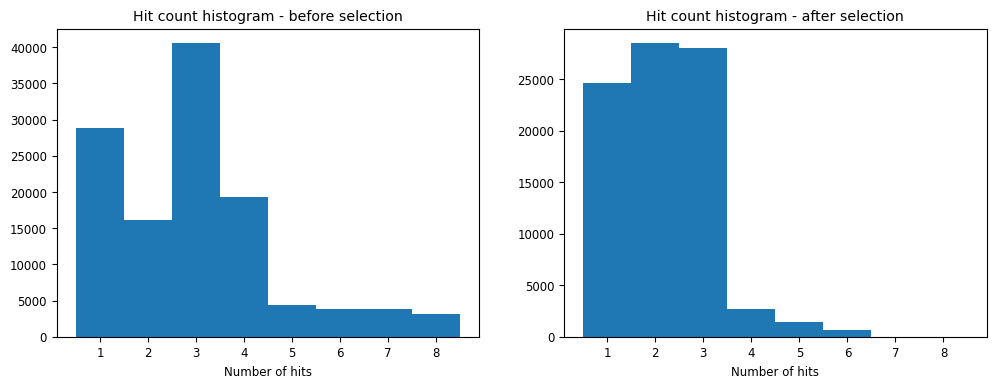

In [25]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plot_hit_count_histogram(original_dataset, title='Hit count histogram - before selection')

plt.subplot(1, 2, 2)
plot_hit_count_histogram(dataset, title='Hit count histogram - after selection')

plt.show()

In [26]:
events_to_view = []
for event, event_data in dataset.items():
    if event_data.get_plane_count() == 4 and event_data.get_hit_count() == 4:
        events_to_view.append(event)
    if len(events_to_view) == 8:
        break
        
events_to_view

[66762, 220899, 246967, 320048, 475173, 499819, 524016, 529681]

(0, 11): 3.27
(1, 2): 0.04
(2, 2): 1.00
(3, 2): 0.20


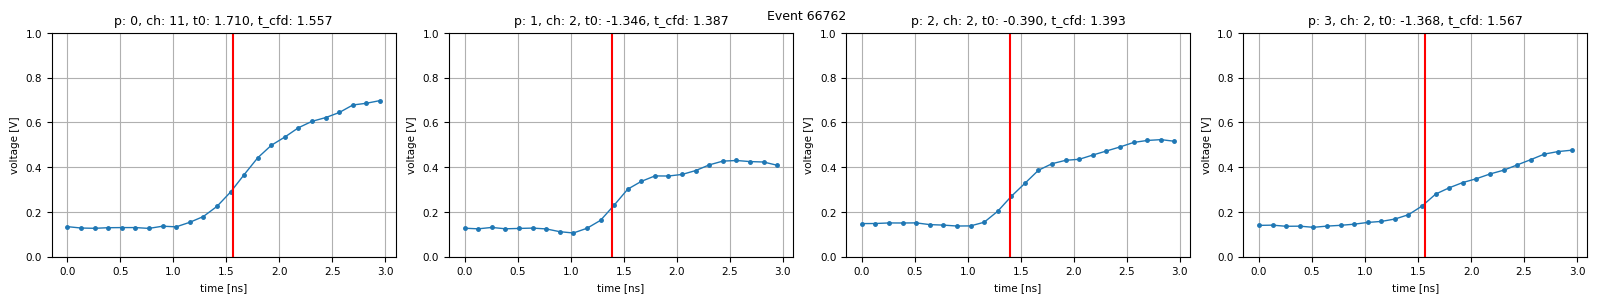

(1, 2): 0.03
(1, 11): -1.02
(2, 11): -0.60
(3, 11): 1.82


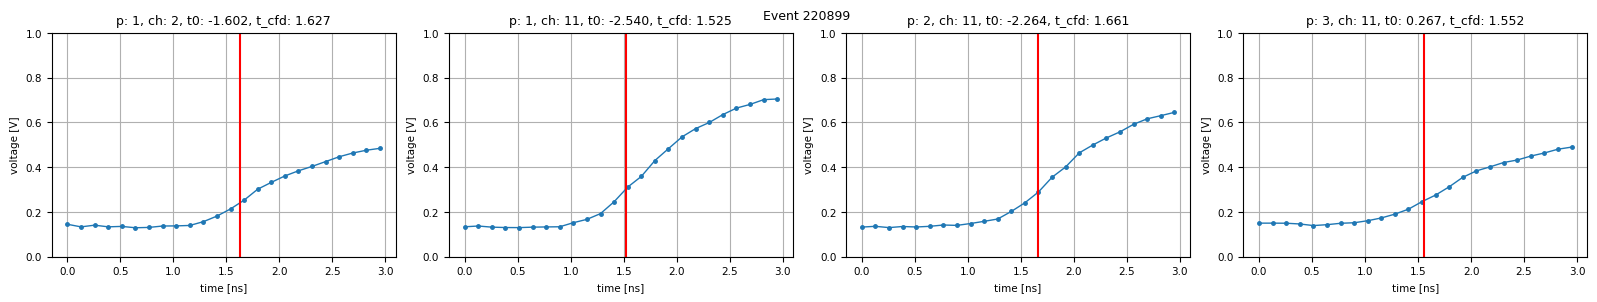

(0, 11): 3.05
(2, 2): 0.76
(3, 2): -0.06
(3, 11): 1.33


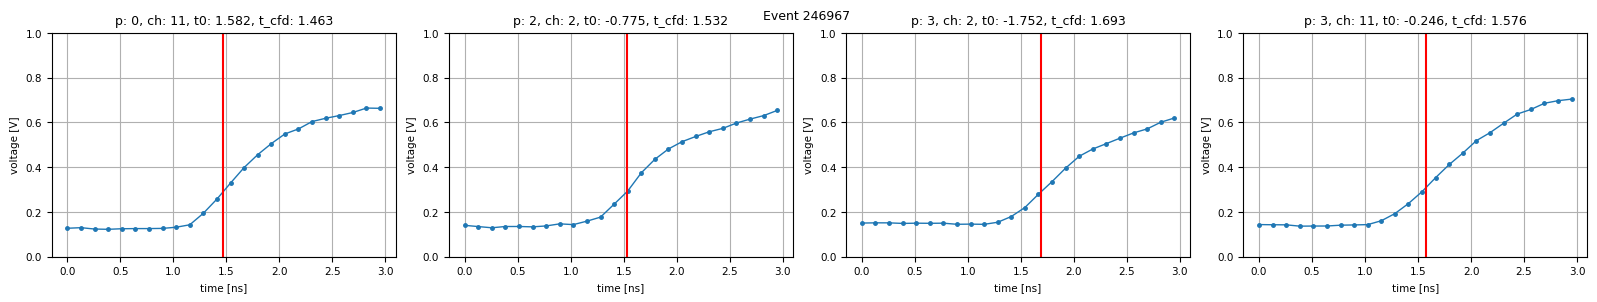

(0, 2): -0.55
(0, 11): 3.45
(2, 2): 1.21
(3, 2): 0.27


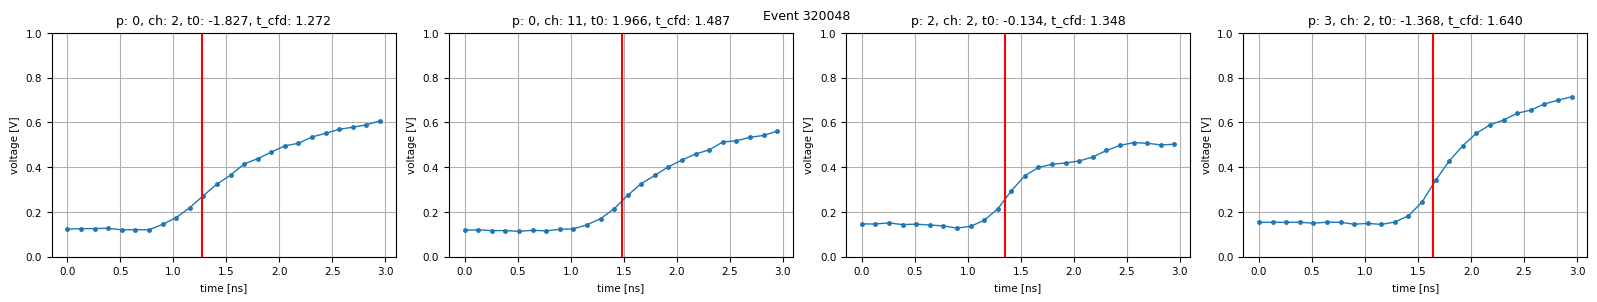

(1, 2): 0.34
(1, 11): -0.64
(2, 2): 1.21
(2, 11): -0.31


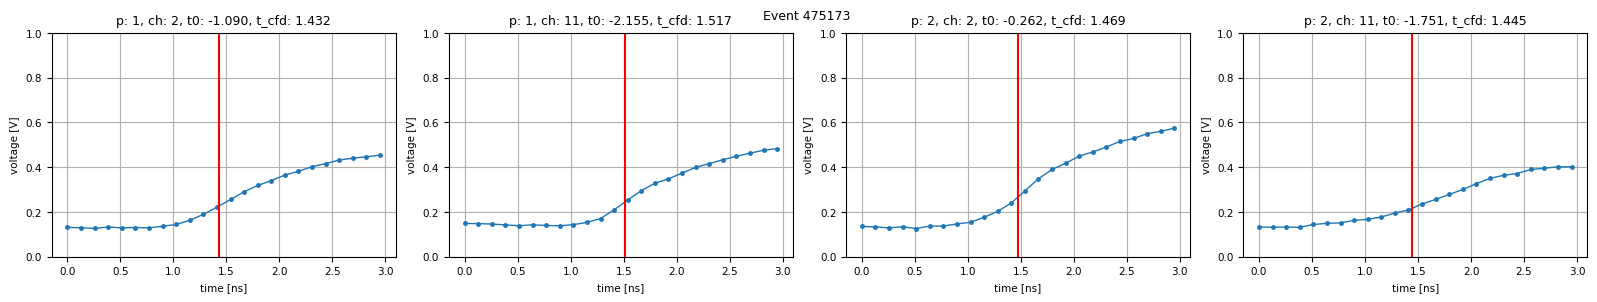

(1, 2): 0.11
(1, 11): -0.55
(2, 11): -0.06
(3, 2): 0.24


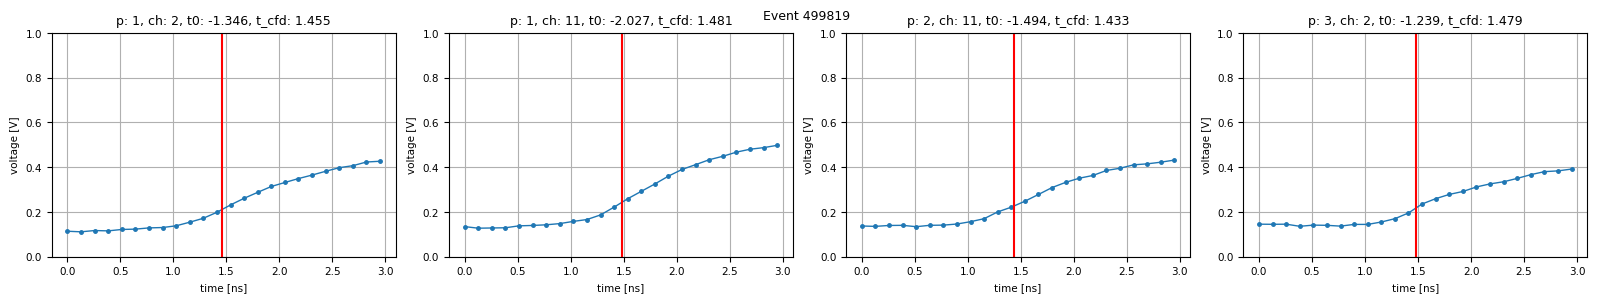

(1, 2): -0.08
(1, 11): -0.73
(2, 2): 0.87
(3, 2): 0.06


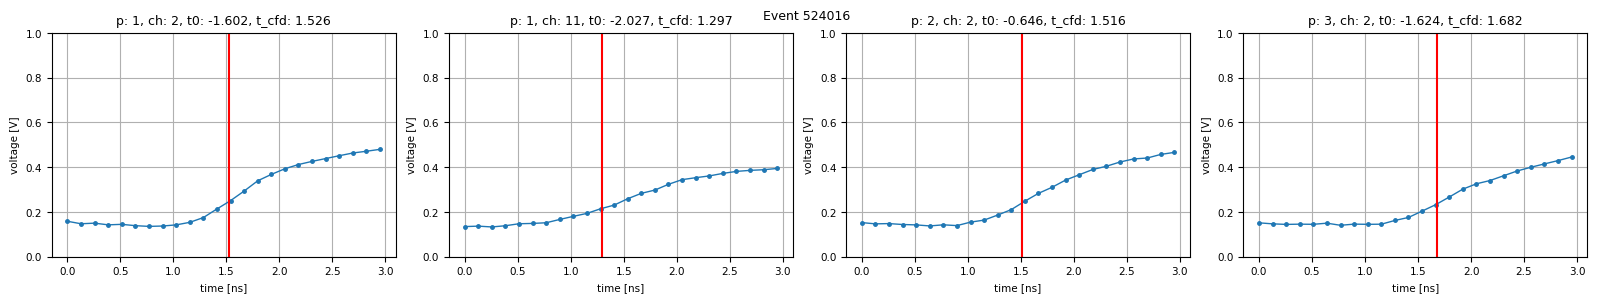

(1, 2): 0.49
(1, 11): -0.69
(2, 11): -0.44
(3, 11): 2.08


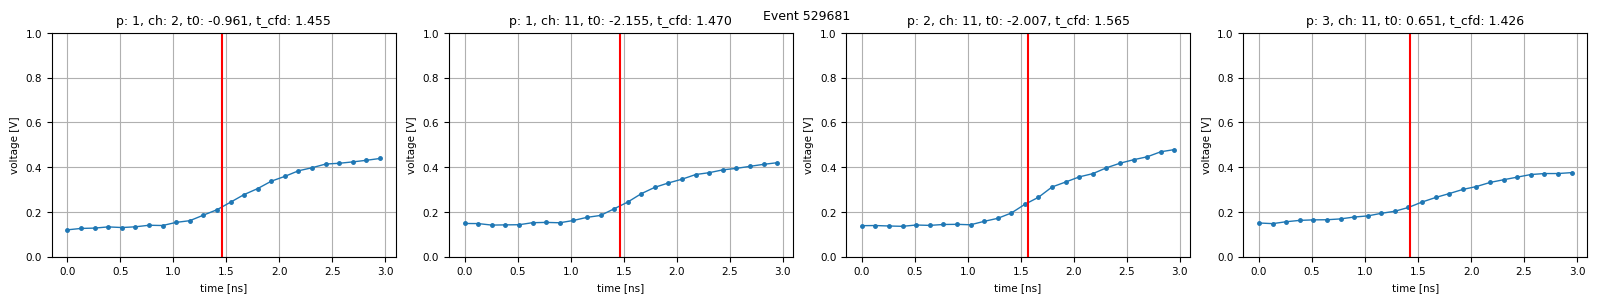

In [27]:
for event in events_to_view:
    plt.figure(figsize=(16, 3))
    plt.rc('font', size=7.5)
    
    for i, (plane, channel, wav_data) in enumerate(dataset[event].get_all_waveforms()):
        plt.subplot(1, 4, i + 1)
        plt.plot(wav_data.series[0], wav_data.series[1], marker='.', linewidth=1, markersize=5)
        if wav_data.t_cfd is not None:
            plt.axvline(wav_data.t_cfd, c='red')
        plt.ylim(0, 1)
        t_cfd_str = f'{wav_data.t_cfd:0.3f}' if wav_data.t_cfd is not None else 'None'
        plt.title(f'p: {plane}, ch: {channel}, t0: {wav_data.t0:0.3f}, t_cfd: {t_cfd_str}')
        plt.xlabel('time [ns]')
        plt.ylabel('voltage [V]')
        plt.grid()
        print(f'({plane}, {channel}): {wav_data.t_cfd + wav_data.t0:0.2f}')
    
    plt.tight_layout()
    plt.suptitle(f'    Event {event}')
    
    plt.show()

In [28]:
for event in events_to_view[:2]:
    print('Event:', event)
    pprint(dataset[event].get_metadata_dict())

Event: 66762
{'plane 0': {'channel 11': "{'t0': 1.7099639581102983, 't_cfd': "
                           '1.5573651747931792}'},
 'plane 1': {'channel 2': "{'t0': -1.3459333159174074, 't_cfd': "
                          '1.3869356335136336}'},
 'plane 2': {'channel 2': "{'t0': -0.3900293981007288, 't_cfd': "
                          '1.3934613723715321}'},
 'plane 3': {'channel 2': "{'t0': -1.3676414577218887, 't_cfd': "
                          '1.5672036889140053}'}}
Event: 220899
{'plane 0': {},
 'plane 1': {'channel 11': "{'t0': -2.5400600081506153, 't_cfd': "
                           '1.524947155592317}',
             'channel 2': "{'t0': -1.6023439146722902, 't_cfd': "
                          '1.6274237489156935}'},
 'plane 2': {'channel 11': "{'t0': -2.263692708839589, 't_cfd': "
                           '1.6607176431213717}'},
 'plane 3': {'channel 11': "{'t0': 0.26674769493883344, 't_cfd': "
                           '1.5518831634111228}'}}
